In [1]:
import geopandas as gpd
import pandas as pd


## Display Spatial data

In [2]:
#download data
spreadurl = 'https://raw.githubusercontent.com/mengluchu/uncertainty/master/data_vis_exp/DENL17_uc.csv'
# load the data
ap = pd.read_csv(spreadurl)
ap_road = ap.filter (regex="road_class_2_50|wkd_day_value|urbantype_ch")

In [3]:
ap_gdf = gpd.GeoDataFrame(ap,crs="EPSG:4326",
                                     geometry=gpd.points_from_xy(ap.Longitude, ap.Latitude))


<AxesSubplot:>

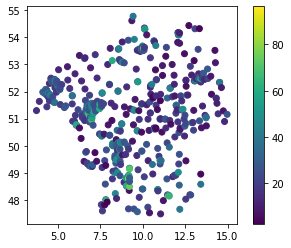

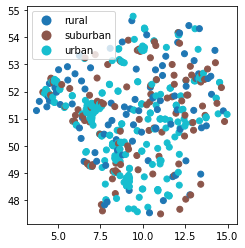

In [4]:
ap_gdf.plot(column = "wkd_day_value", legend = True)
ap_gdf.plot(column = "urbantype_chara", legend = True) 

## More sophisticated mapping: 
design class intervals and put geographical context in background. 

In [39]:
import matplotlib.pyplot as plt # our old friend
import mapclassify # for classificaiton
import contextily as cx # for geographical context. 
#Read more about what contexility can do: https://contextily.readthedocs.io/en/latest/intro_guide.html

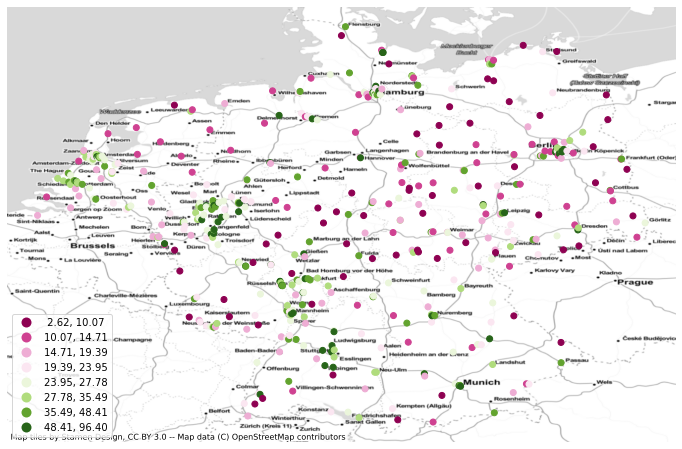

In [67]:
f, ax = plt.subplots(1, figsize=(12, 8))
ap_gdf.plot(column = "wkd_day_value", ax=ax, legend = True, scheme='quantiles', cmap='PiYG', k=8)
# k: number of classes
# scheme, methods for making the classes 
# cmap: color scheme: https://matplotlib.org/stable/tutorials/colors/colormaps.html
cx.add_basemap(ax, crs=ap_gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()
#plt.savefig("NO2.png") # save the plot 
plt.show()


We may prefer to have the greenish color to represent low NO2 and more redish color to represent high NO2. We can conveniently reverse the color scheme by adding the "_r" to the end of the color scheme (here "PiYG" - > "PiYG_r")  

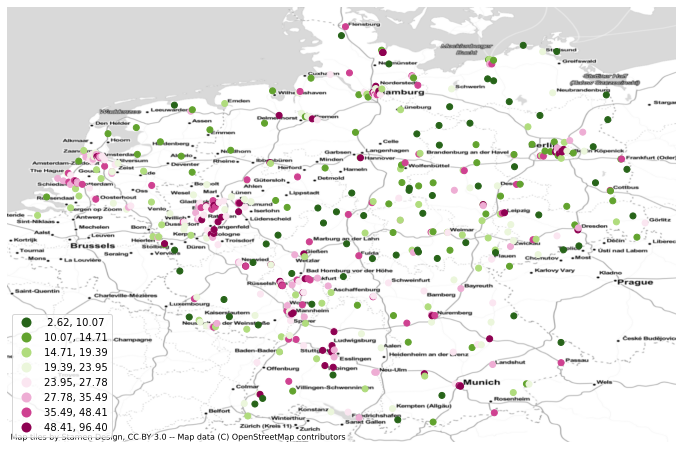

In [65]:

f, ax = plt.subplots(1, figsize=(12, 8))
ap_gdf.plot(column = "wkd_day_value", ax=ax, legend = True, scheme='quantiles', cmap='PiYG_r', k=8)
cx.add_basemap(ax, crs=ap_gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()
#plt.savefig("NO2.png")
plt.show()

In [41]:
# the themes of the contexity are stored in a dictionary. You can see "Stamen" is a key.
cx.providers.keys()
# Remember how we query keys from a dictionary?
#cx.providers["Stamen"]

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])

#### We can try another basemap. 

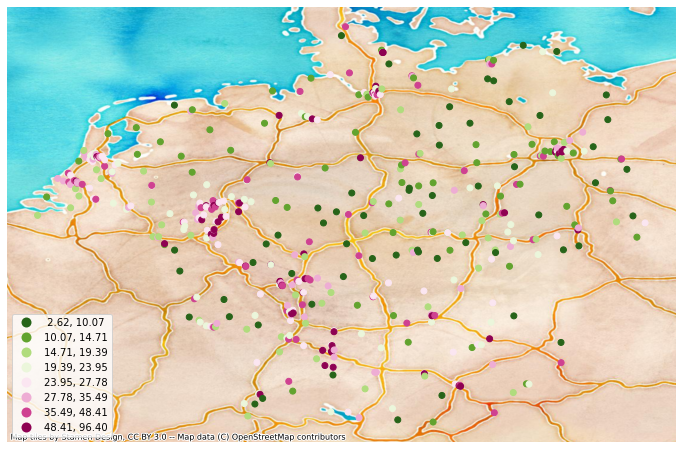

In [63]:

f, ax = plt.subplots(1, figsize=(12, 8))
ap_gdf.plot(column = "wkd_day_value", ax=ax, legend = True, scheme='quantiles', cmap='PiYG_r', k=8)
# k: number of classes
# scheme, methods for making the classes 
# cmap: color scheme
cx.add_basemap(ax, crs=ap_gdf.crs.to_string(), source=cx.providers.Stamen.Watercolor)
ax.set_axis_off()
plt.show()

Read more about what [contexility](https://contextily.readthedocs.io/en/latest/intro_guide.html) can do.

In [68]:
# extract quantiles. 
hv = ap_gdf['wkd_day_value'] 
mapclassify.Quantiles(hv, k=5)

Quantiles             

   Interval      Count
----------------------
[ 2.62, 13.55] |    97
(13.55, 20.29] |    96
(20.29, 27.05] |    96
(27.05, 39.37] |    96
(39.37, 96.40] |    97

In [44]:
q10 = mapclassify.Quantiles(hv, k=10)
q10.bins
q10.counts 

array([49, 48, 48, 48, 48, 48, 48, 48, 48, 49])

## Spatial correlation

“The first law of geography: Everything is related to everything else, but near things are more related than distant things.” Waldo R. Tobler (Tobler 1970)

We can test spatial correlation: whether points close to each other are more similar. 
[PySal](https://pypi.org/project/pysal/) is a Python spatial analysis library. 

Here we use a subset of pysal library. 
"libpysal" is a Python module for the core components of PySAL. 
"esda" is a subpackage of pysal, it includes methods for global and local spatial autocorrelation analysis.


In [45]:
import esda
from libpysal.weights import Queen, KNN, Kernel

Moran's I is a test for global autocorrelation for a continuous attribute. Values of I usually range from −1 to +1. Values significantly below -1/(N-1) indicate negative spatial autocorrelation and values significantly above -1/(N-1) indicate positive spatial autocorrelation.

The first step is to compute a weight matrix. There are many different ways of identify weights, you can have a read of the implemented  [weights in Pysal](https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html).

Let's have a look at four ways: 
1. Queen weight,
2. K-nearest neighbour weight,
3. Kernel weight, with fixed bandwith (determined by K-nearest neighbours). 
5. Kernel weight, with adaptive bandwith (determined by K-nearest neighbours). 


In [46]:
# use a contiguity method, Queen weight:
wq =  Queen.from_dataframe(ap_gdf)
#use a continuous measure of distance to define neighborhoods.
wk = KNN.from_dataframe(ap_gdf, k = 9)
# Gaussian Kernel with fixed bandwith (determined by K-nearest neighbours)
wke_1 = Kernel.from_dataframe(ap_gdf,fixed=True,function='gaussian') 

# Advanced: Gaussian Kernel with adaptive bandwith
#wke_2 = Kernel.from_dataframe(ap_gdf,fixed=False,function='gaussian') 
 

In [47]:
# Using the Queen neighbourhood
mi = esda.moran.Moran(ap_gdf["wkd_day_value"], wq) # calculate Moran's I for the NO2 variable
mi.I

0.20671834762227073

In [48]:
# Use the KNN weights
mi = esda.moran.Moran(ap_gdf["wkd_day_value"], wk)  
mi.I

0.18288691755274733

In [49]:
# Use the gaussian Kernel with fixed weight
mi = esda.moran.Moran(ap_gdf["wkd_day_value"], wke_1)  
mi.I

0.15354419758786625

In [50]:
# Use the gaussian Kernel with adaptive weight
#mi = esda.moran.Moran(ap_gdf["wkd_day_value"], wke_2)  
#mi.I

Now we can visualise results for more insights.
Splot is for visual analytics for spatial analysis with PySAL.

Figures on the left: result of the permutation operation is a reference distribution for the statistic, depicted as a histogram. The red line shows the value of the statistic for the actual data, placed at 0.15 (the Gaussian kernel method) in our example, well to the right of the reference distribution. This suggests a strong rejection of the null hypothesis 
(Inference for Moran’s I is based on a null hypothesis of spatial randomness.) 

Figures on the right: the scatterplot between the attributes (here: wkd_day_values - mean (centred at mean)) and its spatial lags. In its default setting, the plot shows a linear fit through the point cloud. 


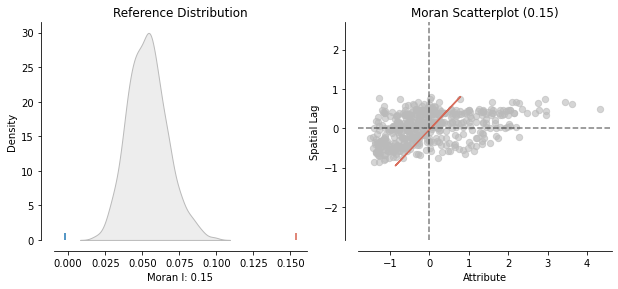

In [51]:
from splot.esda import plot_moran
plot_moran(mi, zstandard=True, figsize=(10,4))
plt.show()

Local Morain'I

In [52]:
li = esda.moran.Moran_Local(ap_gdf["wkd_day_value"], wke_1)

We can distinguish the specific type of local spatial association reflected in the four quadrants of the Moran Scatterplot above:

1. High-High (upper right): high values surounded by neighbours also with high-value. 
2. Low-Low (bottom left)
3. High-Low (lower right)
4. Low-High (upper left)

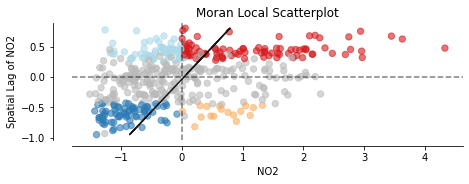

In [53]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(li, p=0.05)
ax.set_xlabel('NO2')
ax.set_ylabel('Spatial Lag of NO2')
plt.show()

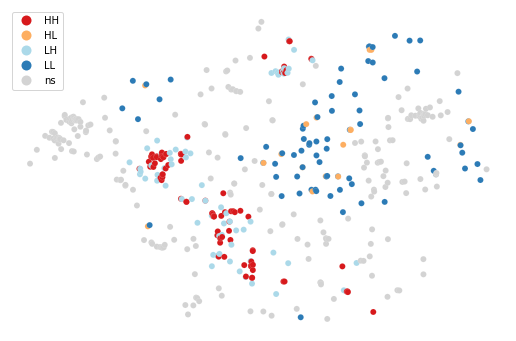

In [54]:
from splot.esda import lisa_cluster
lisa_cluster(li, ap_gdf, p=0.05, figsize = (9,9))
plt.show()